In [34]:
import torch
from matplotlib import pyplot as plt
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.datasets import make_swiss_roll
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from typing import Tuple
import seaborn as sns
from tqdm import trange
import torchvision
import torchvision.transforms as transforms
import os
import pandas as pd
from torchvision import datasets
from torch.utils.data import Dataset
from torchvision.transforms import Compose, ToTensor, Lambda, Resize
from torchvision.datasets.mnist import MNIST, FashionMNIST
import random
from torch.optim import Adam
import einops
import imageio


import diffusers
from dataclasses import dataclass
import torch
import torchvision

import datasets
import diffusers
import accelerate

from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import os
import PIL

data_dir = "./data"
batch_size = 128
SEED = 0
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)


print("pyTorch Available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("CUDA Device Count:", torch.cuda.device_count())
    print("CUDA Current Device:", torch.cuda.current_device())
    print("CUDA Device Name:", torch.cuda.get_device_name(0))
        

    print("pyTorch Version: ", torch.__version__)
    print("pyTorch CUDA Version: ", torch.version.cuda)
#torch.cuda.set_device(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

pyTorch Available: True
CUDA Device Count: 1
CUDA Current Device: 0
CUDA Device Name: NVIDIA GeForce RTX 4050 Laptop GPU
pyTorch Version:  2.5.1
pyTorch CUDA Version:  12.1
cuda


In [12]:
FASHION_CLASSES = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", 
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]

In [13]:
def show_images(images,image_labels=None):
    if isinstance(images, torch.Tensor):
        images = images.detach().cpu().numpy()

    num_images = len(images)
    rows = int(np.sqrt(num_images))
    cols = int(np.ceil(num_images / rows))
    
    fig, axes = plt.subplots(rows, cols, figsize=(8, 8))
    
    for idx, ax in enumerate(axes.flat):
        if idx < num_images:
            ax.imshow(images[idx][0], cmap="gray")
            if image_labels != None:
                ax.set_title(FASHION_CLASSES[image_labels[idx]], fontsize=8)
        ax.axis("off")
    
    plt.tight_layout()
    plt.show()

In [14]:
transform = Compose([
    ToTensor(),
    Lambda(lambda x: (x - 0.5) * 2)]
)
fashion_mnist_dataset = FashionMNIST(data_dir, download=True, train=True, transform=transform)
train_dataloader = DataLoader(fashion_mnist_dataset, batch_size, shuffle=True)

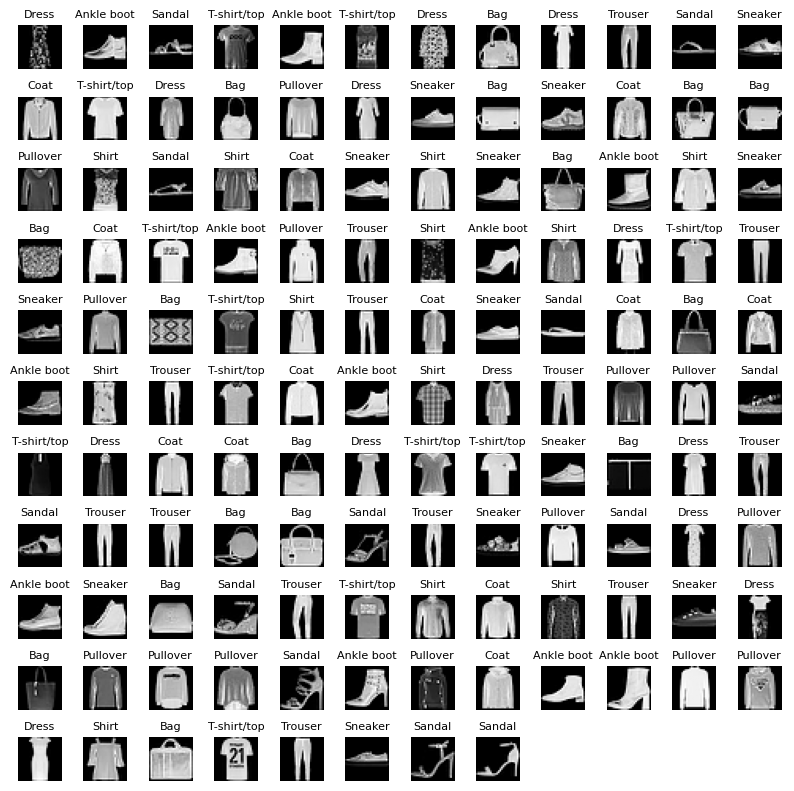

In [15]:
temp_imgs, temp_targets = next(iter(train_dataloader))
show_images(temp_imgs,temp_targets)

### Defining Noise DDPM Module

In [16]:
class DenoisingDiffusionProbabilisticModel(nn.Module):
    def __init__(self, network, n_steps=200, min_beta=10 ** -4, max_beta=0.02, device=None, image_chw=(1, 28, 28)):
        super(DenoisingDiffusionProbabilisticModel, self).__init__()
        self.device = device
        self.n_steps = n_steps
        self.image_chw = image_chw
        self.network = network.to(device)
        
        self.betas = torch.linspace(min_beta, max_beta, n_steps, device=device)
        self.alphas = 1 - self.betas
        self.alpha_bars = torch.cumprod(self.alphas, dim=0)

    def forward(self, x0, t, eta=None):
        if eta is None:
            eta = torch.randn_like(x0, device=self.device)
        
        a_bar_t = self.alpha_bars[t].view(-1, 1, 1, 1)
        return a_bar_t.sqrt() * x0 + (1 - a_bar_t).sqrt() * eta

    def backward(self, x, t):
        return self.network(x, t)

In [17]:
def show_forward(ddpm, loader, device):
    for batch in loader:
        imgs = batch[0].to(device)
        show_images(imgs)
        
        noise_levels = [0.25, 0.5, 0.75, 1.0]
        timesteps = [int(level * ddpm.n_steps) - 1 for level in noise_levels]
        
        for level, t in zip(noise_levels, timesteps):
            noisy_imgs = ddpm(imgs, [t] * len(imgs))
            show_images(noisy_imgs)
            print(f"DDPM Noisy images {int(level * 100)}%")
        
        break

### UNET Architecture

In [18]:
def sinusoidal_embedding(n, d):
    t = torch.arange(n).view(n, 1)
    div_term = torch.exp(torch.arange(0, d, 2) * (-torch.log(torch.tensor(10_000.0)) / d))
    
    embedding = torch.zeros(n, d)
    embedding[:, 0::2] = torch.sin(t * div_term)
    embedding[:, 1::2] = torch.cos(t * div_term)
    
    return embedding

In [19]:
class MyBlock(nn.Module):
    def __init__(self, shape, in_c, out_c, kernel_size=3, stride=1, padding=1, activation=None, normalize=True):
        super(MyBlock, self).__init__()
        self.ln = nn.LayerNorm(shape)
        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size, stride, padding)
        self.conv2 = nn.Conv2d(out_c, out_c, kernel_size, stride, padding)
        self.activation = nn.SiLU() if activation is None else activation
        self.normalize = normalize

    def forward(self, x):
        out = self.ln(x) if self.normalize else x
        out = self.conv1(out)
        out = self.activation(out)
        out = self.conv2(out)
        out = self.activation(out)
        return out

In [20]:
class UNet(nn.Module):
    def __init__(self, n_steps=1000, time_emb_dim=100):
        super(UNet, self).__init__()

        # Sinusoidal embedding
        self.time_embed = nn.Embedding(n_steps, time_emb_dim)
        self.time_embed.weight.data = sinusoidal_embedding(n_steps, time_emb_dim)
        self.time_embed.requires_grad_(False)

        self.te1 = self._make_te(time_emb_dim, 1)
        self.b1 = nn.Sequential(
            MyBlock((1, 28, 28), 1, 10),
            MyBlock((10, 28, 28), 10, 10),
            MyBlock((10, 28, 28), 10, 10)
        )
        self.down1 = nn.Conv2d(10, 10, 4, 2, 1)

        self.te2 = self._make_te(time_emb_dim, 10)
        self.b2 = nn.Sequential(
            MyBlock((10, 14, 14), 10, 20),
            MyBlock((20, 14, 14), 20, 20),
            MyBlock((20, 14, 14), 20, 20)
        )
        self.down2 = nn.Conv2d(20, 20, 4, 2, 1)

        self.te3 = self._make_te(time_emb_dim, 20)
        self.b3 = nn.Sequential(
            MyBlock((20, 7, 7), 20, 40),
            MyBlock((40, 7, 7), 40, 40),
            MyBlock((40, 7, 7), 40, 40)
        )
        self.down3 = nn.Sequential(
            nn.Conv2d(40, 40, 2, 1),
            nn.SiLU(),
            nn.Conv2d(40, 40, 4, 2, 1)
        )

        # Bottleneck
        self.te_mid = self._make_te(time_emb_dim, 40)
        self.b_mid = nn.Sequential(
            MyBlock((40, 3, 3), 40, 20),
            MyBlock((20, 3, 3), 20, 20),
            MyBlock((20, 3, 3), 20, 40)
        )

        # Second half
        self.up1 = nn.Sequential(
            nn.ConvTranspose2d(40, 40, 4, 2, 1),
            nn.SiLU(),
            nn.ConvTranspose2d(40, 40, 2, 1)
        )

        self.te4 = self._make_te(time_emb_dim, 80)
        self.b4 = nn.Sequential(
            MyBlock((80, 7, 7), 80, 40),
            MyBlock((40, 7, 7), 40, 20),
            MyBlock((20, 7, 7), 20, 20)
        )

        self.up2 = nn.ConvTranspose2d(20, 20, 4, 2, 1)
        self.te5 = self._make_te(time_emb_dim, 40)
        self.b5 = nn.Sequential(
            MyBlock((40, 14, 14), 40, 20),
            MyBlock((20, 14, 14), 20, 10),
            MyBlock((10, 14, 14), 10, 10)
        )

        self.up3 = nn.ConvTranspose2d(10, 10, 4, 2, 1)
        self.te_out = self._make_te(time_emb_dim, 20)
        self.b_out = nn.Sequential(
            MyBlock((20, 28, 28), 20, 10),
            MyBlock((10, 28, 28), 10, 10),
            MyBlock((10, 28, 28), 10, 10, normalize=False)
        )

        self.conv_out = nn.Conv2d(10, 1, 3, 1, 1)

    def forward(self, x, t):
        # x is (N, 2, 28, 28) (image with positional embedding stacked on channel dimension)
        t = self.time_embed(t)
        n = len(x)
        out1 = self.b1(x + self.te1(t).reshape(n, -1, 1, 1))  # (N, 10, 28, 28)
        out2 = self.b2(self.down1(out1) + self.te2(t).reshape(n, -1, 1, 1))  # (N, 20, 14, 14)
        out3 = self.b3(self.down2(out2) + self.te3(t).reshape(n, -1, 1, 1))  # (N, 40, 7, 7)

        out_mid = self.b_mid(self.down3(out3) + self.te_mid(t).reshape(n, -1, 1, 1))  # (N, 40, 3, 3)

        out4 = torch.cat((out3, self.up1(out_mid)), dim=1)  # (N, 80, 7, 7)
        out4 = self.b4(out4 + self.te4(t).reshape(n, -1, 1, 1))  # (N, 20, 7, 7)

        out5 = torch.cat((out2, self.up2(out4)), dim=1)  # (N, 40, 14, 14)
        out5 = self.b5(out5 + self.te5(t).reshape(n, -1, 1, 1))  # (N, 10, 14, 14)

        out = torch.cat((out1, self.up3(out5)), dim=1)  # (N, 20, 28, 28)
        out = self.b_out(out + self.te_out(t).reshape(n, -1, 1, 1))  # (N, 1, 28, 28)

        out = self.conv_out(out)

        return out

    def _make_te(self, dim_in, dim_out):
        return nn.Sequential(
            nn.Linear(dim_in, dim_out),
            nn.SiLU(),
            nn.Linear(dim_out, dim_out)
        )

In [21]:
n_steps, min_beta, max_beta = 1000, 10 ** -4, 0.02
ddpm = DenoisingDiffusionProbabilisticModel(UNet(n_steps), n_steps=n_steps, min_beta=min_beta, max_beta=max_beta, device=device)

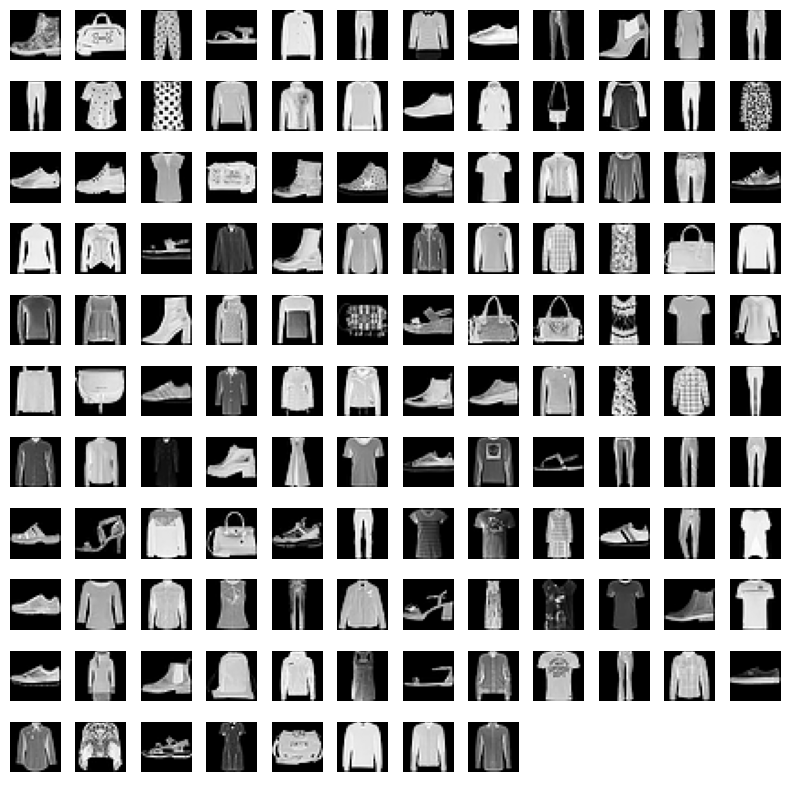

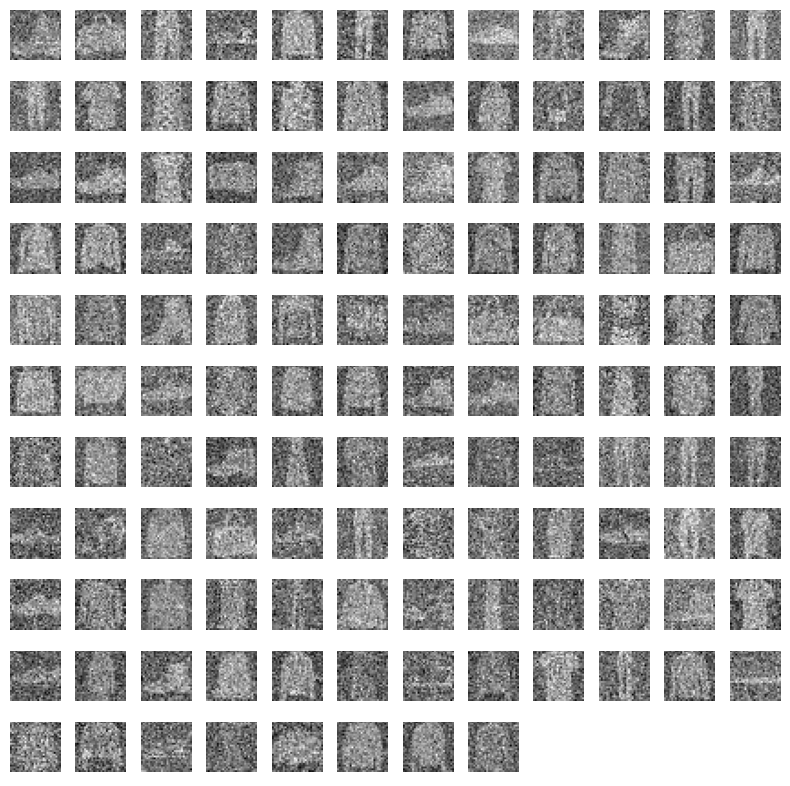

DDPM Noisy images 25%


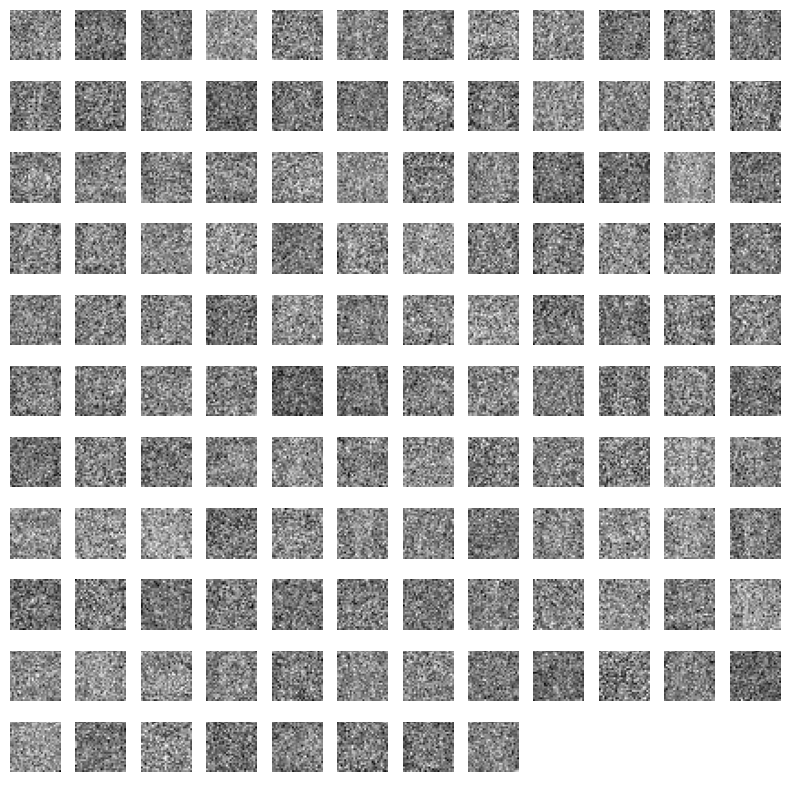

DDPM Noisy images 50%


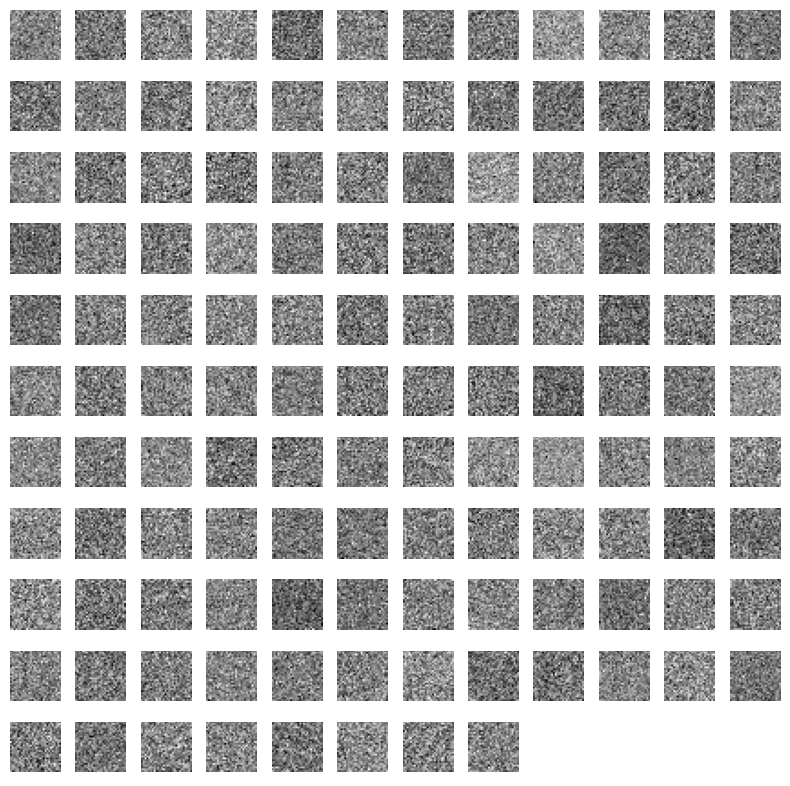

DDPM Noisy images 75%


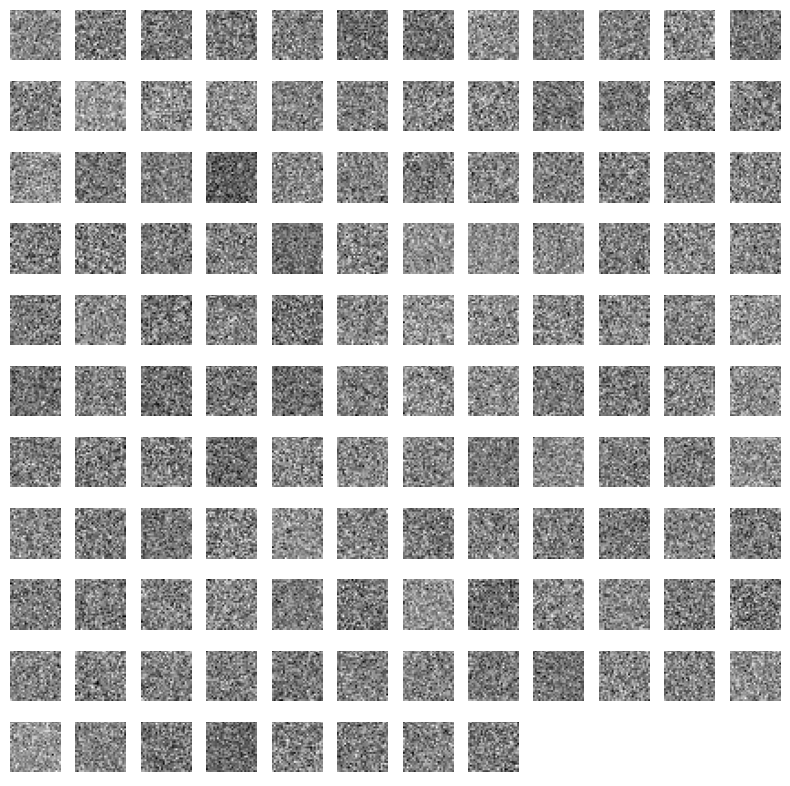

DDPM Noisy images 100%


In [22]:
show_forward(ddpm, train_dataloader, device)

### Training the Model

In [32]:
def training_loop(ddpm, loader, n_epochs, optim, device, display=False, store_path="ddpm_fashion_mnist.pt"):
    mse = nn.MSELoss()
    best_loss = float("inf")
    n_steps = ddpm.n_steps

    for epoch in tqdm(range(n_epochs), desc=f"Training progress", colour="#00ff00"):
        epoch_loss = 0.0
        for step, batch in enumerate(tqdm(loader, leave=False, desc=f"Epoch {epoch + 1}/{n_epochs}", colour="#005500")):
            x0 = batch[0].to(device)
            n = len(x0)

            eta = torch.randn_like(x0).to(device)
            t = torch.randint(0, n_steps, (n,)).to(device)

            noisy_imgs = ddpm(x0, t, eta)

            eta_theta = ddpm.backward(noisy_imgs, t.reshape(n, -1))

            loss = mse(eta_theta, eta)
            optim.zero_grad()
            loss.backward()
            optim.step()

            epoch_loss += loss.item() * len(x0) / len(loader.dataset)

        if display:
            show_images(generate_new_images(ddpm, device=device), f"Images generated at epoch {epoch + 1}")

        log_string = f"Loss at epoch {epoch + 1}: {epoch_loss:.3f}"

        if best_loss > epoch_loss:
            best_loss = epoch_loss
            torch.save(ddpm.state_dict(), store_path)
            log_string += " --> Best model ever (stored)"

        print(log_string)

In [25]:
# Training
store_path = "ddpm_fashion_mnist.pt"
n_epochs = 20
lr = 0.001
training_loop(ddpm, train_dataloader, n_epochs, optim=Adam(ddpm.parameters(), lr), device=device, store_path=store_path)

Training progress:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/20:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 1: 0.199 --> Best model ever (stored)


Epoch 2/20:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 2: 0.077 --> Best model ever (stored)


Epoch 3/20:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 3: 0.066 --> Best model ever (stored)


Epoch 4/20:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 4: 0.062 --> Best model ever (stored)


Epoch 5/20:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 5: 0.059 --> Best model ever (stored)


Epoch 6/20:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 6: 0.057 --> Best model ever (stored)


Epoch 7/20:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 7: 0.055 --> Best model ever (stored)


Epoch 8/20:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 8: 0.054 --> Best model ever (stored)


Epoch 9/20:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 9: 0.053 --> Best model ever (stored)


Epoch 10/20:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 10: 0.052 --> Best model ever (stored)


Epoch 11/20:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 11: 0.051 --> Best model ever (stored)


Epoch 12/20:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 12: 0.050 --> Best model ever (stored)


Epoch 13/20:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 13: 0.050 --> Best model ever (stored)


Epoch 14/20:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 14: 0.051


Epoch 15/20:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 15: 0.049 --> Best model ever (stored)


Epoch 16/20:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 16: 0.049 --> Best model ever (stored)


Epoch 17/20:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 17: 0.048 --> Best model ever (stored)


Epoch 18/20:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 18: 0.048 --> Best model ever (stored)


Epoch 19/20:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 19: 0.048 --> Best model ever (stored)


Epoch 20/20:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 20: 0.048


### Visualizing the trained Model

In [26]:
def generate_new_images(ddpm, n_samples=16, device=None, frames_per_gif=100, gif_name="result.gif", c=1, h=28, w=28):
    frame_idxs = np.linspace(0, ddpm.n_steps, frames_per_gif).astype(np.uint)
    frames = []

    with torch.no_grad():
        if device is None:
            device = ddpm.device

        # Starting from random noise
        x = torch.randn(n_samples, c, h, w).to(device)

        for idx, t in enumerate(list(range(ddpm.n_steps))[::-1]):
            # Estimating noise to be removed
            time_tensor = (torch.ones(n_samples, 1) * t).to(device).long()
            eta_theta = ddpm.backward(x, time_tensor)

            alpha_t = ddpm.alphas[t]
            alpha_t_bar = ddpm.alpha_bars[t]

            # Partially denoising the image
            x = (1 / alpha_t.sqrt()) * (x - (1 - alpha_t) / (1 - alpha_t_bar).sqrt() * eta_theta)

            if t > 0:
                z = torch.randn(n_samples, c, h, w).to(device)

                # Option 1: sigma_t squared = beta_t
                beta_t = ddpm.betas[t]
                sigma_t = beta_t.sqrt()

                # Option 2: sigma_t squared = beta_tilda_t
                # prev_alpha_t_bar = ddpm.alpha_bars[t-1] if t > 0 else ddpm.alphas[0]
                # beta_tilda_t = ((1 - prev_alpha_t_bar)/(1 - alpha_t_bar)) * beta_t
                # sigma_t = beta_tilda_t.sqrt()

                # Adding some more noise like in Langevin Dynamics fashion
                x = x + sigma_t * z

            if idx in frame_idxs or t == 0:
                normalized = x.clone()
                for i in range(len(normalized)):
                    normalized[i] -= torch.min(normalized[i])
                    normalized[i] *= 255 / torch.max(normalized[i])

                frame = einops.rearrange(normalized, "(b1 b2) c h w -> (b1 h) (b2 w) c", b1=int(n_samples ** 0.5))
                frame = frame.cpu().numpy().astype(np.uint8)

                frames.append(frame)

    with imageio.get_writer(gif_name, mode="I") as writer:
        for idx, frame in enumerate(frames):
            rgb_frame = np.repeat(frame, 3, axis=2)
            writer.append_data(rgb_frame)

            if idx == len(frames) - 1:
                last_rgb_frame = np.repeat(frames[-1], 3, axis=2)
                for _ in range(frames_per_gif // 3):
                    writer.append_data(last_rgb_frame)
    return x

In [30]:
# Loading the trained model
best_model = DenoisingDiffusionProbabilisticModel(UNet(), n_steps=n_steps, device=device)
best_model.load_state_dict(torch.load(store_path, map_location=device))
best_model.eval()
print("Model loaded")

C:\Users\chock\AppData\Local\Temp\ipykernel_50648\903678987.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load(store_path, map_locatio

Model loaded


Generating new images


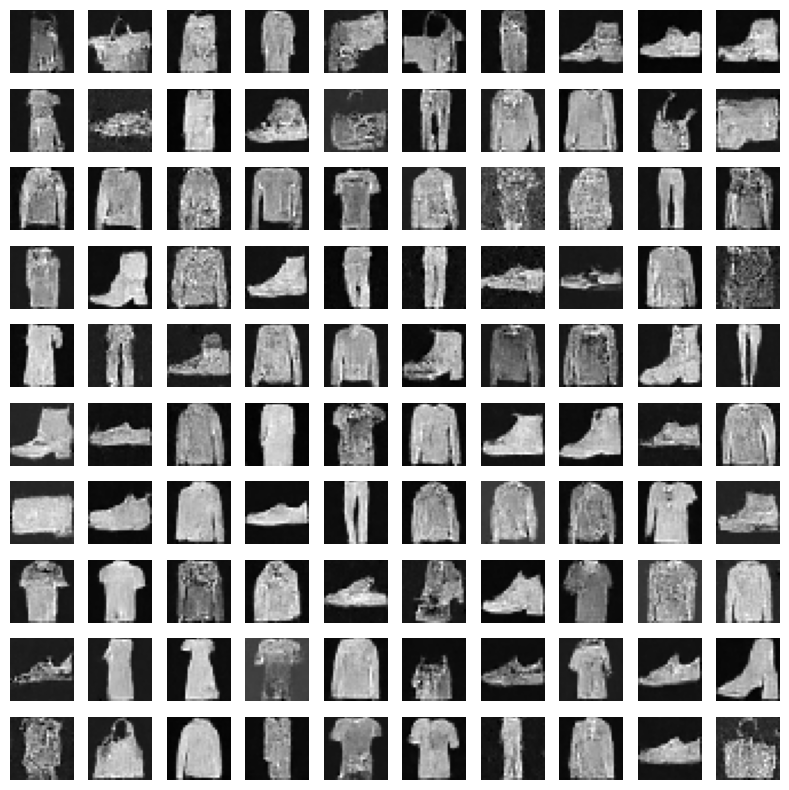

In [33]:
print("Generating new images")

generated = generate_new_images(
        best_model,
        n_samples=100,
        device=device,
        gif_name="fashion.gif"
    )
show_images(generated)